# Model and Training

## Load the model

In [1]:
import os
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from diffusers import UNet2DModel, DDPMScheduler, DDIMScheduler
ON_COLAB = False  # Set to True if running on Google Colab
if ON_COLAB:
    !pip install dotenv
    
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()


# Configuration
target_size_for_training = (128, 128)
data_root = f"./raw_data"  # root directory containing 'train' and 'test' subfolders
if ON_COLAB:
    from google.colab import drive

    drive.mount(os.getenv("GOOGLE_DRIVE_CONTENT_PATH", "/content/drive"))
    data_root = os.getenv("GOOGLE_DRIVE_PATH_RESIZED", data_root)

train_dir = os.path.join(data_root, "train")
test_dir = os.path.join(data_root, "test")
model_save_dir = os.getenv("MODEL_SAVE_DIR", "./checkpoints")
os.makedirs(model_save_dir, exist_ok=True)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 1e-4
IMAGE_SIZE = target_size_for_training[0]

# 2. Define the UNet diffusion model
from model_enrico import get_unet_model

model = get_unet_model(
    sample_size=IMAGE_SIZE,
    in_channels=1,
    out_channels=1,
    layers_per_block=2,
    block_out_channels=(64, 128, 256),
    down_block_types=("DownBlock2D", "DownBlock2D", "AttnDownBlock2D"),
    up_block_types=("AttnUpBlock2D", "UpBlock2D", "UpBlock2D"),
    dropout=0.1,
).to(DEVICE)

# Print model summary
def print_model_summary(model):
    print("Model Summary:")
    print(f"Model Type: {type(model).__name__}")
    print(f"Number of Parameters: {sum(p.numel() for p in model.parameters())}")
    print(f"Device: {next(model.parameters()).device}")

print_model_summary(model)


# 5. Load the model checkpoint if available
def load_checkpoint(ckpt_path, model, optimizer=None, device=torch.device("cpu")):
    loaded = False
    if not os.path.exists(ckpt_path):
        print(f"No checkpoint found at {ckpt_path}, starting fresh.")
        return loaded, model, optimizer, 0

    checkpoint = torch.load(ckpt_path, map_location=device)
    
    # Rimuovi il prefisso "_orig_mod." dalle chiavi se presente
    new_state_dict = {}
    for k, v in checkpoint["model"].items():
        if k.startswith("_orig_mod."):
            new_k = k.replace("_orig_mod.", "")
            new_state_dict[new_k] = v
        else:
            new_state_dict[k] = v
    
    model.load_state_dict(new_state_dict)
    model.to(device)
    loaded = True
    start_epoch = checkpoint.get("epoch", 0)
    
    if optimizer is not None and "optimizer" in checkpoint:
        optimizer.load_state_dict(checkpoint["optimizer"])
        print(f"Loaded optimizer state from checkpoint '{ckpt_path}'")
    else:
        print("Optimizer state not found in checkpoint, starting with a new optimizer.")
    
    print(f"Loaded checkpoint '{ckpt_path}' (epoch {start_epoch})")
    return loaded, model, optimizer, start_epoch


WEIGHT_DECAY = 1e-5  # weight decay for regularization
optimizer = torch.optim.Adam(
    model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
)

# Load the model checkpoint
ckpt = "checkpoints/ddim_unet_epoch1.pth"
isModelLoadedFromCheckpoint, model, optimizer, start_epoch = load_checkpoint(
    ckpt, model, optimizer, device=DEVICE
)
model.eval()
if isModelLoadedFromCheckpoint:
    print(f"Model {ckpt.split('/')[-1]} loaded and moved to {DEVICE}, starting from epoch {start_epoch}.")
else:
    print(f"Model {ckpt.split('/')[-1]} not found. Starting from scratch, loaded on {DEVICE}, starting from epoch {start_epoch}.")

/home/enrico/Desktop/Project-Correction/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Model Summary:
Model Type: UNet2DModel
Number of Parameters: 15722625
Device: cuda:0
No checkpoint found at checkpoints/ddim_unet_epoch1.pth, starting fresh.
Model ddim_unet_epoch1.pth not found. Starting from scratch, loaded on cuda, starting from epoch 0.


## Training and validation

In [2]:
import os
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.amp import autocast, GradScaler
from matplotlib import pyplot as plt
from utils import NUM_TRAIN_TIMESTEPS, sample_images, AugmentedDataset, save_checkpoint

# Config
BATCH_SIZE = 16
NUM_EPOCHS = 20
IMAGE_EXTENSIONS = (".png", ".jpg", ".jpeg")


# Dataset Preparation
def count_images(root_dir, extensions=IMAGE_EXTENSIONS):
    return sum(
        fname.lower().endswith(extensions)
        for _, _, filenames in os.walk(root_dir)
        for fname in filenames
    )


print(f"Training images before augmentation: {count_images(train_dir)}")
print(f"Validation images before augmentation: {count_images(test_dir)}")

train_dataset = AugmentedDataset(root_dir=train_dir, image_size=IMAGE_SIZE)
test_dataset = AugmentedDataset(root_dir=test_dir, image_size=IMAGE_SIZE)

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True
)
test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True
)

print(f"Training samples: {len(train_loader.dataset)}")
print(f"Validation samples: {len(test_loader.dataset)}")

# Scheduler and Model Setup
noise_scheduler = DDPMScheduler(num_train_timesteps=NUM_TRAIN_TIMESTEPS)
ddim_scheduler = DDIMScheduler(
    beta_start=noise_scheduler.config.beta_start,
    beta_end=noise_scheduler.config.beta_end,
    beta_schedule=noise_scheduler.config.beta_schedule,
    clip_sample=False,
)
ddim_scheduler.set_timesteps(NUM_TRAIN_TIMESTEPS)

model = torch.compile(model)
scaler = GradScaler(device=DEVICE)
scheduler = CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=1e-6)

# Training Loop
train_losses, val_losses = [], []

print(
    f"Training on {DEVICE} | Batch Size: {BATCH_SIZE} | Epochs: {NUM_EPOCHS} | Starting at epoch {start_epoch}"
)

for epoch in range(1, NUM_EPOCHS + 1):
    model.train()
    total_train_loss = 0.0

    for step, (images, _) in enumerate(train_loader, 1):
        images = images.to(DEVICE)
        noise = torch.randn_like(images)
        timesteps = torch.randint(
            0, NUM_TRAIN_TIMESTEPS, (images.size(0),), device=DEVICE
        )

        optimizer.zero_grad()
        with autocast(device_type=DEVICE.type, enabled=True):
            noisy_images = noise_scheduler.add_noise(images, noise, timesteps)
            noise_pred = model(noisy_images, timesteps).sample
            loss = F.mse_loss(noise_pred, noise)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        total_train_loss += loss.item()

        if step % 50 == 0 or step == len(train_loader):
            print(
                f"[Epoch {epoch}/{NUM_EPOCHS} | Step {step}/{len(train_loader)}] Train Loss: {loss.item():.6f}"
            )

        # if step % (len(train_loader) // 3) == 0:
        #     print(f"Reached step {step} of epoch {epoch}. Saving sample image and weights.")
        #     sample_images(
        #         output_path=f"{model_save_dir}/epoch_{epoch + start_epoch}_step_{step}.png",
        #         num_steps=NUM_TRAIN_TIMESTEPS,
        #         DEVICE=DEVICE,
        #         IMAGE_SIZE=IMAGE_SIZE,
        #         model=model,
        #         ddim_scheduler=ddim_scheduler,
        #     )
        #     ckpt_path = os.path.join(
        #         model_save_dir, f"ddim_unet_epoch{epoch + start_epoch}_step{step}.pth"
        #     )
        #     save_checkpoint(
        #         model=model,
        #         optimizer=optimizer,
        #         epoch=epoch + start_epoch,
        #         path=ckpt_path,
        #     )

    sample_images(
        output_path=f"{model_save_dir}/epoch_{epoch + start_epoch}.png",
        num_steps=NUM_TRAIN_TIMESTEPS,
        DEVICE=DEVICE,
        IMAGE_SIZE=IMAGE_SIZE,
        model=model,
        ddim_scheduler=ddim_scheduler,
    )

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch} complete. Avg Train Loss: {avg_train_loss:.6f}")

    # Validation
    model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(DEVICE)
            noise = torch.randn_like(images)
            timesteps = torch.randint(
                0, NUM_TRAIN_TIMESTEPS, (images.size(0),), device=DEVICE
            )

            with autocast(device_type=DEVICE.type, enabled=True):
                noisy_images = noise_scheduler.add_noise(images, noise, timesteps)
                noise_pred = model(noisy_images, timesteps).sample
                total_val_loss += F.mse_loss(noise_pred, noise).item()

    avg_val_loss = total_val_loss / len(test_loader)
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch} complete. Avg Validation Loss: {avg_val_loss:.6f}")

    ckpt_path = os.path.join(
        model_save_dir, f"ddim_unet_epoch{epoch + start_epoch}.pth"
    )
    save_checkpoint(
        model=model,
        optimizer=optimizer,
        epoch=epoch + start_epoch,
        path=ckpt_path,
    )

Training images before augmentation: 3306
Validation images before augmentation: 327
Training samples: 13224
Validation samples: 1308
Training on cuda | Batch Size: 16 | Epochs: 20 | Starting at epoch 0
[Epoch 1/20 | Step 50/827] Train Loss: 0.044299
[Epoch 1/20 | Step 100/827] Train Loss: 0.079445
[Epoch 1/20 | Step 150/827] Train Loss: 0.102406
[Epoch 1/20 | Step 200/827] Train Loss: 0.027396
[Epoch 1/20 | Step 250/827] Train Loss: 0.027174
[Epoch 1/20 | Step 300/827] Train Loss: 0.016116
[Epoch 1/20 | Step 350/827] Train Loss: 0.028958
[Epoch 1/20 | Step 400/827] Train Loss: 0.020110
[Epoch 1/20 | Step 450/827] Train Loss: 0.024278
[Epoch 1/20 | Step 500/827] Train Loss: 0.027964
[Epoch 1/20 | Step 550/827] Train Loss: 0.012218
[Epoch 1/20 | Step 600/827] Train Loss: 0.013063
[Epoch 1/20 | Step 650/827] Train Loss: 0.019272
[Epoch 1/20 | Step 700/827] Train Loss: 0.018045
[Epoch 1/20 | Step 750/827] Train Loss: 0.012017
[Epoch 1/20 | Step 800/827] Train Loss: 0.027028
[Epoch 1/20 | 

Sampling DDIM: 100%|██████████| 1000/1000 [00:25<00:00, 39.48it/s]


Sample saved to ./checkpoints/epoch_1.png
Epoch 1 complete. Avg Train Loss: 0.041336
Epoch 1 complete. Avg Validation Loss: 0.015513
Checkpoint salvato in: ./checkpoints/ddim_unet_epoch1.pth
[Epoch 2/20 | Step 50/827] Train Loss: 0.026884
[Epoch 2/20 | Step 100/827] Train Loss: 0.012382
[Epoch 2/20 | Step 150/827] Train Loss: 0.014294
[Epoch 2/20 | Step 200/827] Train Loss: 0.009331
[Epoch 2/20 | Step 250/827] Train Loss: 0.021569
[Epoch 2/20 | Step 300/827] Train Loss: 0.013747
[Epoch 2/20 | Step 350/827] Train Loss: 0.012275
[Epoch 2/20 | Step 400/827] Train Loss: 0.010894
[Epoch 2/20 | Step 450/827] Train Loss: 0.013149
[Epoch 2/20 | Step 500/827] Train Loss: 0.015871
[Epoch 2/20 | Step 550/827] Train Loss: 0.013021
[Epoch 2/20 | Step 600/827] Train Loss: 0.007319
[Epoch 2/20 | Step 650/827] Train Loss: 0.036182
[Epoch 2/20 | Step 700/827] Train Loss: 0.009155
[Epoch 2/20 | Step 750/827] Train Loss: 0.023938
[Epoch 2/20 | Step 800/827] Train Loss: 0.013631
[Epoch 2/20 | Step 827/827

Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.88it/s]

Sample saved to ./checkpoints/epoch_2.png
Epoch 2 complete. Avg Train Loss: 0.017869


Epoch 2 complete. Avg Validation Loss: 0.015238
Checkpoint salvato in: ./checkpoints/ddim_unet_epoch2.pth
[Epoch 3/20 | Step 50/827] Train Loss: 0.005155
[Epoch 3/20 | Step 100/827] Train Loss: 0.011852
[Epoch 3/20 | Step 150/827] Train Loss: 0.028702
[Epoch 3/20 | Step 200/827] Train Loss: 0.008809
[Epoch 3/20 | Step 250/827] Train Loss: 0.006056
[Epoch 3/20 | Step 300/827] Train Loss: 0.009292
[Epoch 3/20 | Step 350/827] Train Loss: 0.014130
[Epoch 3/20 | Step 400/827] Train Loss: 0.007280
[Epoch 3/20 | Step 450/827] Train Loss: 0.013492
[Epoch 3/20 | Step 500/827] Train Loss: 0.007067
[Epoch 3/20 | Step 550/827] Train Loss: 0.015775
[Epoch 3/20 | Step 600/827] Train Loss: 0.017182
[Epoch 3/20 | Step 650/827] Train Loss: 0.011330
[Epoch 3/20 | Step 700/827] Train Loss: 0.010486
[Epoch 3/20 | Step 750/827] Train Loss: 0.020939
[Epoch 3/20 | Step 800/827] Train Loss: 0.011223
[Epoch 3/20 | Step 827/827] Train Loss: 0.002970


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.89it/s]

Sample saved to ./checkpoints/epoch_3.png
Epoch 3 complete. Avg Train Loss: 0.014688


Epoch 3 complete. Avg Validation Loss: 0.011597
Checkpoint salvato in: ./checkpoints/ddim_unet_epoch3.pth
[Epoch 4/20 | Step 50/827] Train Loss: 0.012143
[Epoch 4/20 | Step 100/827] Train Loss: 0.004797
[Epoch 4/20 | Step 150/827] Train Loss: 0.021708
[Epoch 4/20 | Step 200/827] Train Loss: 0.036841
[Epoch 4/20 | Step 250/827] Train Loss: 0.018636
[Epoch 4/20 | Step 300/827] Train Loss: 0.004767
[Epoch 4/20 | Step 350/827] Train Loss: 0.008176
[Epoch 4/20 | Step 400/827] Train Loss: 0.008688
[Epoch 4/20 | Step 450/827] Train Loss: 0.009602
[Epoch 4/20 | Step 500/827] Train Loss: 0.007587
[Epoch 4/20 | Step 550/827] Train Loss: 0.008468
[Epoch 4/20 | Step 600/827] Train Loss: 0.007949
[Epoch 4/20 | Step 650/827] Train Loss: 0.009252
[Epoch 4/20 | Step 700/827] Train Loss: 0.011099
[Epoch 4/20 | Step 750/827] Train Loss: 0.002472
[Epoch 4/20 | Step 800/827] Train Loss: 0.037904
[Epoch 4/20 | Step 827/827] Train Loss: 0.031480


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.50it/s]


Sample saved to ./checkpoints/epoch_4.png
Epoch 4 complete. Avg Train Loss: 0.013540
Epoch 4 complete. Avg Validation Loss: 0.010422
Checkpoint salvato in: ./checkpoints/ddim_unet_epoch4.pth
[Epoch 5/20 | Step 50/827] Train Loss: 0.005717
[Epoch 5/20 | Step 100/827] Train Loss: 0.016114
[Epoch 5/20 | Step 150/827] Train Loss: 0.011206
[Epoch 5/20 | Step 200/827] Train Loss: 0.006258
[Epoch 5/20 | Step 250/827] Train Loss: 0.013023
[Epoch 5/20 | Step 300/827] Train Loss: 0.003986
[Epoch 5/20 | Step 350/827] Train Loss: 0.013585
[Epoch 5/20 | Step 400/827] Train Loss: 0.007959
[Epoch 5/20 | Step 450/827] Train Loss: 0.004908
[Epoch 5/20 | Step 500/827] Train Loss: 0.013637
[Epoch 5/20 | Step 550/827] Train Loss: 0.019056
[Epoch 5/20 | Step 600/827] Train Loss: 0.017475
[Epoch 5/20 | Step 650/827] Train Loss: 0.028393
[Epoch 5/20 | Step 700/827] Train Loss: 0.004613
[Epoch 5/20 | Step 750/827] Train Loss: 0.008294
[Epoch 5/20 | Step 800/827] Train Loss: 0.005014
[Epoch 5/20 | Step 827/827

Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.68it/s]

Sample saved to ./checkpoints/epoch_5.png
Epoch 5 complete. Avg Train Loss: 0.012163


Epoch 5 complete. Avg Validation Loss: 0.010088
Checkpoint salvato in: ./checkpoints/ddim_unet_epoch5.pth
[Epoch 6/20 | Step 50/827] Train Loss: 0.042883
[Epoch 6/20 | Step 100/827] Train Loss: 0.006392
[Epoch 6/20 | Step 150/827] Train Loss: 0.006550
[Epoch 6/20 | Step 200/827] Train Loss: 0.006875
[Epoch 6/20 | Step 250/827] Train Loss: 0.006362
[Epoch 6/20 | Step 300/827] Train Loss: 0.006549
[Epoch 6/20 | Step 350/827] Train Loss: 0.003083
[Epoch 6/20 | Step 400/827] Train Loss: 0.004940
[Epoch 6/20 | Step 450/827] Train Loss: 0.022765
[Epoch 6/20 | Step 500/827] Train Loss: 0.023295
[Epoch 6/20 | Step 550/827] Train Loss: 0.016567
[Epoch 6/20 | Step 600/827] Train Loss: 0.020847
[Epoch 6/20 | Step 650/827] Train Loss: 0.008924
[Epoch 6/20 | Step 700/827] Train Loss: 0.012222
[Epoch 6/20 | Step 750/827] Train Loss: 0.009879
[Epoch 6/20 | Step 800/827] Train Loss: 0.026331
[Epoch 6/20 | Step 827/827] Train Loss: 0.016572


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.75it/s]


Sample saved to ./checkpoints/epoch_6.png
Epoch 6 complete. Avg Train Loss: 0.011738
Epoch 6 complete. Avg Validation Loss: 0.011142
Checkpoint salvato in: ./checkpoints/ddim_unet_epoch6.pth
[Epoch 7/20 | Step 50/827] Train Loss: 0.022187
[Epoch 7/20 | Step 100/827] Train Loss: 0.033084
[Epoch 7/20 | Step 150/827] Train Loss: 0.004350
[Epoch 7/20 | Step 200/827] Train Loss: 0.012982
[Epoch 7/20 | Step 250/827] Train Loss: 0.006281
[Epoch 7/20 | Step 300/827] Train Loss: 0.001867
[Epoch 7/20 | Step 350/827] Train Loss: 0.022626
[Epoch 7/20 | Step 400/827] Train Loss: 0.018246
[Epoch 7/20 | Step 450/827] Train Loss: 0.021792
[Epoch 7/20 | Step 500/827] Train Loss: 0.002843
[Epoch 7/20 | Step 550/827] Train Loss: 0.010875
[Epoch 7/20 | Step 600/827] Train Loss: 0.023508
[Epoch 7/20 | Step 650/827] Train Loss: 0.015215
[Epoch 7/20 | Step 700/827] Train Loss: 0.004953
[Epoch 7/20 | Step 750/827] Train Loss: 0.002877
[Epoch 7/20 | Step 800/827] Train Loss: 0.007176
[Epoch 7/20 | Step 827/827

Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.27it/s]


Sample saved to ./checkpoints/epoch_7.png
Epoch 7 complete. Avg Train Loss: 0.010767
Epoch 7 complete. Avg Validation Loss: 0.011846
Checkpoint salvato in: ./checkpoints/ddim_unet_epoch7.pth
[Epoch 8/20 | Step 50/827] Train Loss: 0.004430
[Epoch 8/20 | Step 100/827] Train Loss: 0.009250
[Epoch 8/20 | Step 150/827] Train Loss: 0.008223
[Epoch 8/20 | Step 200/827] Train Loss: 0.005317
[Epoch 8/20 | Step 250/827] Train Loss: 0.006697
[Epoch 8/20 | Step 300/827] Train Loss: 0.004111
[Epoch 8/20 | Step 350/827] Train Loss: 0.017865
[Epoch 8/20 | Step 400/827] Train Loss: 0.006870
[Epoch 8/20 | Step 450/827] Train Loss: 0.006357
[Epoch 8/20 | Step 500/827] Train Loss: 0.032280
[Epoch 8/20 | Step 550/827] Train Loss: 0.040827
[Epoch 8/20 | Step 600/827] Train Loss: 0.011108
[Epoch 8/20 | Step 650/827] Train Loss: 0.007982
[Epoch 8/20 | Step 700/827] Train Loss: 0.009565
[Epoch 8/20 | Step 750/827] Train Loss: 0.010863
[Epoch 8/20 | Step 800/827] Train Loss: 0.005950
[Epoch 8/20 | Step 827/827

Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.69it/s]

Sample saved to ./checkpoints/epoch_8.png
Epoch 8 complete. Avg Train Loss: 0.010896


Epoch 8 complete. Avg Validation Loss: 0.010344
Checkpoint salvato in: ./checkpoints/ddim_unet_epoch8.pth
[Epoch 9/20 | Step 50/827] Train Loss: 0.014296
[Epoch 9/20 | Step 100/827] Train Loss: 0.009028
[Epoch 9/20 | Step 150/827] Train Loss: 0.005841
[Epoch 9/20 | Step 200/827] Train Loss: 0.014113
[Epoch 9/20 | Step 250/827] Train Loss: 0.009290
[Epoch 9/20 | Step 300/827] Train Loss: 0.005479
[Epoch 9/20 | Step 350/827] Train Loss: 0.011910
[Epoch 9/20 | Step 400/827] Train Loss: 0.006073
[Epoch 9/20 | Step 450/827] Train Loss: 0.002663
[Epoch 9/20 | Step 500/827] Train Loss: 0.004202
[Epoch 9/20 | Step 550/827] Train Loss: 0.006087
[Epoch 9/20 | Step 600/827] Train Loss: 0.008326
[Epoch 9/20 | Step 650/827] Train Loss: 0.006232
[Epoch 9/20 | Step 700/827] Train Loss: 0.002247
[Epoch 9/20 | Step 750/827] Train Loss: 0.034678
[Epoch 9/20 | Step 800/827] Train Loss: 0.014261
[Epoch 9/20 | Step 827/827] Train Loss: 0.001480


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.57it/s]

Sample saved to ./checkpoints/epoch_9.png
Epoch 9 complete. Avg Train Loss: 0.010978


Epoch 9 complete. Avg Validation Loss: 0.010817
Checkpoint salvato in: ./checkpoints/ddim_unet_epoch9.pth
[Epoch 10/20 | Step 50/827] Train Loss: 0.037822
[Epoch 10/20 | Step 100/827] Train Loss: 0.007586
[Epoch 10/20 | Step 150/827] Train Loss: 0.011962
[Epoch 10/20 | Step 200/827] Train Loss: 0.008015
[Epoch 10/20 | Step 250/827] Train Loss: 0.005014
[Epoch 10/20 | Step 300/827] Train Loss: 0.004925
[Epoch 10/20 | Step 350/827] Train Loss: 0.009753
[Epoch 10/20 | Step 400/827] Train Loss: 0.011591
[Epoch 10/20 | Step 450/827] Train Loss: 0.005758
[Epoch 10/20 | Step 500/827] Train Loss: 0.013808
[Epoch 10/20 | Step 550/827] Train Loss: 0.008920
[Epoch 10/20 | Step 600/827] Train Loss: 0.011993
[Epoch 10/20 | Step 650/827] Train Loss: 0.029052
[Epoch 10/20 | Step 700/827] Train Loss: 0.006227
[Epoch 10/20 | Step 750/827] Train Loss: 0.002925
[Epoch 10/20 | Step 800/827] Train Loss: 0.006694
[Epoch 10/20 | Step 827/827] Train Loss: 0.017554


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.80it/s]

Sample saved to ./checkpoints/epoch_10.png
Epoch 10 complete. Avg Train Loss: 0.010569


Epoch 10 complete. Avg Validation Loss: 0.009176
Checkpoint salvato in: ./checkpoints/ddim_unet_epoch10.pth
[Epoch 11/20 | Step 50/827] Train Loss: 0.003396
[Epoch 11/20 | Step 100/827] Train Loss: 0.016744
[Epoch 11/20 | Step 150/827] Train Loss: 0.011326
[Epoch 11/20 | Step 200/827] Train Loss: 0.019653
[Epoch 11/20 | Step 250/827] Train Loss: 0.002404
[Epoch 11/20 | Step 300/827] Train Loss: 0.004202
[Epoch 11/20 | Step 350/827] Train Loss: 0.016438
[Epoch 11/20 | Step 400/827] Train Loss: 0.004563
[Epoch 11/20 | Step 450/827] Train Loss: 0.007105
[Epoch 11/20 | Step 500/827] Train Loss: 0.006058
[Epoch 11/20 | Step 550/827] Train Loss: 0.004719
[Epoch 11/20 | Step 600/827] Train Loss: 0.015472
[Epoch 11/20 | Step 650/827] Train Loss: 0.011494
[Epoch 11/20 | Step 700/827] Train Loss: 0.004998
[Epoch 11/20 | Step 750/827] Train Loss: 0.007280
[Epoch 11/20 | Step 800/827] Train Loss: 0.014173
[Epoch 11/20 | Step 827/827] Train Loss: 0.004375


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.86it/s]

Sample saved to ./checkpoints/epoch_11.png
Epoch 11 complete. Avg Train Loss: 0.010069


Epoch 11 complete. Avg Validation Loss: 0.010312
Checkpoint salvato in: ./checkpoints/ddim_unet_epoch11.pth
[Epoch 12/20 | Step 50/827] Train Loss: 0.009427
[Epoch 12/20 | Step 100/827] Train Loss: 0.002556
[Epoch 12/20 | Step 150/827] Train Loss: 0.006182
[Epoch 12/20 | Step 200/827] Train Loss: 0.002826
[Epoch 12/20 | Step 250/827] Train Loss: 0.002027
[Epoch 12/20 | Step 300/827] Train Loss: 0.004159
[Epoch 12/20 | Step 350/827] Train Loss: 0.009188
[Epoch 12/20 | Step 400/827] Train Loss: 0.016117
[Epoch 12/20 | Step 450/827] Train Loss: 0.019697
[Epoch 12/20 | Step 500/827] Train Loss: 0.009608
[Epoch 12/20 | Step 550/827] Train Loss: 0.003314
[Epoch 12/20 | Step 600/827] Train Loss: 0.003881
[Epoch 12/20 | Step 650/827] Train Loss: 0.011943
[Epoch 12/20 | Step 700/827] Train Loss: 0.032209
[Epoch 12/20 | Step 750/827] Train Loss: 0.007597
[Epoch 12/20 | Step 800/827] Train Loss: 0.003391
[Epoch 12/20 | Step 827/827] Train Loss: 0.005968


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.79it/s]

Sample saved to ./checkpoints/epoch_12.png
Epoch 12 complete. Avg Train Loss: 0.010445


Epoch 12 complete. Avg Validation Loss: 0.010452
Checkpoint salvato in: ./checkpoints/ddim_unet_epoch12.pth
[Epoch 13/20 | Step 50/827] Train Loss: 0.004580
[Epoch 13/20 | Step 100/827] Train Loss: 0.006070
[Epoch 13/20 | Step 150/827] Train Loss: 0.006310
[Epoch 13/20 | Step 200/827] Train Loss: 0.006475
[Epoch 13/20 | Step 250/827] Train Loss: 0.026481
[Epoch 13/20 | Step 300/827] Train Loss: 0.003183
[Epoch 13/20 | Step 350/827] Train Loss: 0.007106
[Epoch 13/20 | Step 400/827] Train Loss: 0.005945
[Epoch 13/20 | Step 450/827] Train Loss: 0.006593
[Epoch 13/20 | Step 500/827] Train Loss: 0.009535
[Epoch 13/20 | Step 550/827] Train Loss: 0.014145
[Epoch 13/20 | Step 600/827] Train Loss: 0.006059
[Epoch 13/20 | Step 650/827] Train Loss: 0.004016
[Epoch 13/20 | Step 700/827] Train Loss: 0.020784
[Epoch 13/20 | Step 750/827] Train Loss: 0.006451
[Epoch 13/20 | Step 800/827] Train Loss: 0.010457
[Epoch 13/20 | Step 827/827] Train Loss: 0.003184


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 45.00it/s]

Sample saved to ./checkpoints/epoch_13.png
Epoch 13 complete. Avg Train Loss: 0.009773


Epoch 13 complete. Avg Validation Loss: 0.010478
Checkpoint salvato in: ./checkpoints/ddim_unet_epoch13.pth
[Epoch 14/20 | Step 50/827] Train Loss: 0.007441
[Epoch 14/20 | Step 100/827] Train Loss: 0.006472
[Epoch 14/20 | Step 150/827] Train Loss: 0.008785
[Epoch 14/20 | Step 200/827] Train Loss: 0.010352
[Epoch 14/20 | Step 250/827] Train Loss: 0.012988
[Epoch 14/20 | Step 300/827] Train Loss: 0.005086
[Epoch 14/20 | Step 350/827] Train Loss: 0.009728
[Epoch 14/20 | Step 400/827] Train Loss: 0.011382
[Epoch 14/20 | Step 450/827] Train Loss: 0.018540
[Epoch 14/20 | Step 500/827] Train Loss: 0.006323
[Epoch 14/20 | Step 550/827] Train Loss: 0.003190
[Epoch 14/20 | Step 600/827] Train Loss: 0.007363
[Epoch 14/20 | Step 650/827] Train Loss: 0.007675
[Epoch 14/20 | Step 700/827] Train Loss: 0.005417
[Epoch 14/20 | Step 750/827] Train Loss: 0.005597
[Epoch 14/20 | Step 800/827] Train Loss: 0.017203
[Epoch 14/20 | Step 827/827] Train Loss: 0.016113


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.77it/s]

Sample saved to ./checkpoints/epoch_14.png
Epoch 14 complete. Avg Train Loss: 0.009646


Epoch 14 complete. Avg Validation Loss: 0.010061
Checkpoint salvato in: ./checkpoints/ddim_unet_epoch14.pth
[Epoch 15/20 | Step 50/827] Train Loss: 0.010859
[Epoch 15/20 | Step 100/827] Train Loss: 0.004151
[Epoch 15/20 | Step 150/827] Train Loss: 0.004450
[Epoch 15/20 | Step 200/827] Train Loss: 0.004425
[Epoch 15/20 | Step 250/827] Train Loss: 0.007472
[Epoch 15/20 | Step 300/827] Train Loss: 0.012123
[Epoch 15/20 | Step 350/827] Train Loss: 0.006424
[Epoch 15/20 | Step 400/827] Train Loss: 0.025791
[Epoch 15/20 | Step 450/827] Train Loss: 0.004870
[Epoch 15/20 | Step 500/827] Train Loss: 0.001971
[Epoch 15/20 | Step 550/827] Train Loss: 0.009180
[Epoch 15/20 | Step 600/827] Train Loss: 0.006697
[Epoch 15/20 | Step 650/827] Train Loss: 0.003493
[Epoch 15/20 | Step 700/827] Train Loss: 0.014420
[Epoch 15/20 | Step 750/827] Train Loss: 0.045649
[Epoch 15/20 | Step 800/827] Train Loss: 0.022520
[Epoch 15/20 | Step 827/827] Train Loss: 0.006912


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.76it/s]

Sample saved to ./checkpoints/epoch_15.png
Epoch 15 complete. Avg Train Loss: 0.009611


Epoch 15 complete. Avg Validation Loss: 0.010006
Checkpoint salvato in: ./checkpoints/ddim_unet_epoch15.pth
[Epoch 16/20 | Step 50/827] Train Loss: 0.006642
[Epoch 16/20 | Step 100/827] Train Loss: 0.009026
[Epoch 16/20 | Step 150/827] Train Loss: 0.006493
[Epoch 16/20 | Step 200/827] Train Loss: 0.011011
[Epoch 16/20 | Step 250/827] Train Loss: 0.024351
[Epoch 16/20 | Step 300/827] Train Loss: 0.006188
[Epoch 16/20 | Step 350/827] Train Loss: 0.027524
[Epoch 16/20 | Step 400/827] Train Loss: 0.002492
[Epoch 16/20 | Step 450/827] Train Loss: 0.013759
[Epoch 16/20 | Step 500/827] Train Loss: 0.009147
[Epoch 16/20 | Step 550/827] Train Loss: 0.013251
[Epoch 16/20 | Step 600/827] Train Loss: 0.010140
[Epoch 16/20 | Step 650/827] Train Loss: 0.016389
[Epoch 16/20 | Step 700/827] Train Loss: 0.004574
[Epoch 16/20 | Step 750/827] Train Loss: 0.034891
[Epoch 16/20 | Step 800/827] Train Loss: 0.009608
[Epoch 16/20 | Step 827/827] Train Loss: 0.009059


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.81it/s]

Sample saved to ./checkpoints/epoch_16.png
Epoch 16 complete. Avg Train Loss: 0.009824


Epoch 16 complete. Avg Validation Loss: 0.009145
Checkpoint salvato in: ./checkpoints/ddim_unet_epoch16.pth
[Epoch 17/20 | Step 50/827] Train Loss: 0.004981
[Epoch 17/20 | Step 100/827] Train Loss: 0.010228
[Epoch 17/20 | Step 150/827] Train Loss: 0.004394
[Epoch 17/20 | Step 200/827] Train Loss: 0.009186
[Epoch 17/20 | Step 250/827] Train Loss: 0.005473
[Epoch 17/20 | Step 300/827] Train Loss: 0.006140
[Epoch 17/20 | Step 350/827] Train Loss: 0.009030
[Epoch 17/20 | Step 400/827] Train Loss: 0.004029
[Epoch 17/20 | Step 450/827] Train Loss: 0.011965
[Epoch 17/20 | Step 500/827] Train Loss: 0.008828
[Epoch 17/20 | Step 550/827] Train Loss: 0.015144
[Epoch 17/20 | Step 600/827] Train Loss: 0.008130
[Epoch 17/20 | Step 650/827] Train Loss: 0.010766
[Epoch 17/20 | Step 700/827] Train Loss: 0.020214
[Epoch 17/20 | Step 750/827] Train Loss: 0.002809
[Epoch 17/20 | Step 800/827] Train Loss: 0.007950
[Epoch 17/20 | Step 827/827] Train Loss: 0.026913


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.67it/s]

Sample saved to ./checkpoints/epoch_17.png
Epoch 17 complete. Avg Train Loss: 0.009399


Epoch 17 complete. Avg Validation Loss: 0.009110
Checkpoint salvato in: ./checkpoints/ddim_unet_epoch17.pth
[Epoch 18/20 | Step 50/827] Train Loss: 0.005989
[Epoch 18/20 | Step 100/827] Train Loss: 0.004724
[Epoch 18/20 | Step 150/827] Train Loss: 0.004723
[Epoch 18/20 | Step 200/827] Train Loss: 0.014882
[Epoch 18/20 | Step 250/827] Train Loss: 0.012701
[Epoch 18/20 | Step 300/827] Train Loss: 0.010502
[Epoch 18/20 | Step 350/827] Train Loss: 0.005909
[Epoch 18/20 | Step 400/827] Train Loss: 0.006420
[Epoch 18/20 | Step 450/827] Train Loss: 0.005299
[Epoch 18/20 | Step 500/827] Train Loss: 0.008561
[Epoch 18/20 | Step 550/827] Train Loss: 0.016400
[Epoch 18/20 | Step 600/827] Train Loss: 0.039454
[Epoch 18/20 | Step 650/827] Train Loss: 0.023751
[Epoch 18/20 | Step 700/827] Train Loss: 0.009158
[Epoch 18/20 | Step 750/827] Train Loss: 0.009918
[Epoch 18/20 | Step 800/827] Train Loss: 0.002573
[Epoch 18/20 | Step 827/827] Train Loss: 0.003574


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.82it/s]

Sample saved to ./checkpoints/epoch_18.png
Epoch 18 complete. Avg Train Loss: 0.009763


Epoch 18 complete. Avg Validation Loss: 0.010060
Checkpoint salvato in: ./checkpoints/ddim_unet_epoch18.pth
[Epoch 19/20 | Step 50/827] Train Loss: 0.004944
[Epoch 19/20 | Step 100/827] Train Loss: 0.004843
[Epoch 19/20 | Step 150/827] Train Loss: 0.003270
[Epoch 19/20 | Step 200/827] Train Loss: 0.018140
[Epoch 19/20 | Step 250/827] Train Loss: 0.003717
[Epoch 19/20 | Step 300/827] Train Loss: 0.003810
[Epoch 19/20 | Step 350/827] Train Loss: 0.008227
[Epoch 19/20 | Step 400/827] Train Loss: 0.013516
[Epoch 19/20 | Step 450/827] Train Loss: 0.019846
[Epoch 19/20 | Step 500/827] Train Loss: 0.003001
[Epoch 19/20 | Step 550/827] Train Loss: 0.013326
[Epoch 19/20 | Step 600/827] Train Loss: 0.010691
[Epoch 19/20 | Step 650/827] Train Loss: 0.004212
[Epoch 19/20 | Step 700/827] Train Loss: 0.005122
[Epoch 19/20 | Step 750/827] Train Loss: 0.006029
[Epoch 19/20 | Step 800/827] Train Loss: 0.008945
[Epoch 19/20 | Step 827/827] Train Loss: 0.010520


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.72it/s]

Sample saved to ./checkpoints/epoch_19.png
Epoch 19 complete. Avg Train Loss: 0.009532


Epoch 19 complete. Avg Validation Loss: 0.009097
Checkpoint salvato in: ./checkpoints/ddim_unet_epoch19.pth
[Epoch 20/20 | Step 50/827] Train Loss: 0.008147
[Epoch 20/20 | Step 100/827] Train Loss: 0.006396
[Epoch 20/20 | Step 150/827] Train Loss: 0.019803
[Epoch 20/20 | Step 200/827] Train Loss: 0.001707
[Epoch 20/20 | Step 250/827] Train Loss: 0.008853
[Epoch 20/20 | Step 300/827] Train Loss: 0.005909
[Epoch 20/20 | Step 350/827] Train Loss: 0.018692
[Epoch 20/20 | Step 400/827] Train Loss: 0.008198
[Epoch 20/20 | Step 450/827] Train Loss: 0.009122
[Epoch 20/20 | Step 500/827] Train Loss: 0.003767
[Epoch 20/20 | Step 550/827] Train Loss: 0.004092
[Epoch 20/20 | Step 600/827] Train Loss: 0.005603
[Epoch 20/20 | Step 650/827] Train Loss: 0.011484
[Epoch 20/20 | Step 700/827] Train Loss: 0.006822
[Epoch 20/20 | Step 750/827] Train Loss: 0.006386
[Epoch 20/20 | Step 800/827] Train Loss: 0.041114
[Epoch 20/20 | Step 827/827] Train Loss: 0.002949


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.75it/s]

Sample saved to ./checkpoints/epoch_20.png
Epoch 20 complete. Avg Train Loss: 0.009763


Epoch 20 complete. Avg Validation Loss: 0.010842
Checkpoint salvato in: ./checkpoints/ddim_unet_epoch20.pth


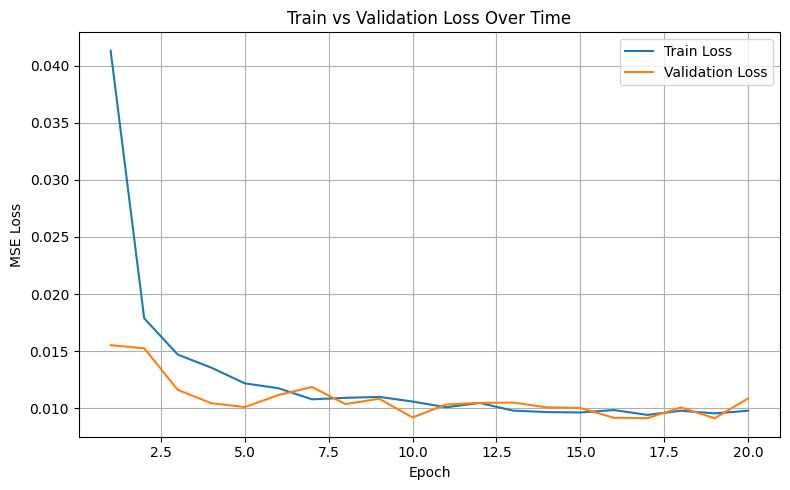

In [3]:
import os
import numpy as np

# Path to the loss history file
history_file = os.path.join(model_save_dir, "loss_history.txt")

# Load existing history if it exists
all_train_losses = []
all_val_losses = []

if os.path.exists(history_file):
    with open(history_file, "r") as f:
        lines = f.readlines()[1:]  # Skip header
        for line in lines:
            _, train_loss, val_loss = line.strip().split("\t")
            all_train_losses.append(float(train_loss))
            all_val_losses.append(float(val_loss))

# Append current session's losses
all_train_losses.extend(train_losses)
all_val_losses.extend(val_losses)

# Save updated history
with open(history_file, "w") as f:
    f.write("Epoch\tTrain Loss\tValidation Loss\n")
    for i, (tr, vl) in enumerate(zip(all_train_losses, all_val_losses), 1):
        f.write(f"{i}\t{tr:.6f}\t{vl:.6f}\n")

# Plot full loss history
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(all_train_losses) + 1), all_train_losses, label="Train Loss")
plt.plot(range(1, len(all_val_losses) + 1), all_val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Train vs Validation Loss Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [4]:
from diffusers import DDPMScheduler, DDIMScheduler
from tqdm import tqdm
from utils import sample_images

# Imposta il numero di step di inferenza per DDIM (uguale a NUM_TRAIN_TIMESTEPS di default)
# 6. Sampling example with DDIM
noise_scheduler = DDPMScheduler(num_train_timesteps=NUM_TRAIN_TIMESTEPS)

ddim_scheduler = DDIMScheduler(
    beta_start=noise_scheduler.config.beta_start,
    beta_end=noise_scheduler.config.beta_end,
    beta_schedule=noise_scheduler.config.beta_schedule,
    clip_sample=False,
)

ddim_scheduler.set_timesteps(NUM_TRAIN_TIMESTEPS)


# Sample images
for i in range(10):
    sample_images(
        output_path=f"result/ddim_sample_epoch{epoch + start_epoch}_{i}.png",
        num_steps=NUM_TRAIN_TIMESTEPS,
        DEVICE=DEVICE,
        IMAGE_SIZE=IMAGE_SIZE,
        model=model,
        ddim_scheduler=ddim_scheduler,
    )

Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.48it/s]


Sample saved to result/ddim_sample_epoch20_0.png


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.61it/s]


Sample saved to result/ddim_sample_epoch20_1.png


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.96it/s]


Sample saved to result/ddim_sample_epoch20_2.png


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.74it/s]


Sample saved to result/ddim_sample_epoch20_3.png


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.65it/s]


Sample saved to result/ddim_sample_epoch20_4.png


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.62it/s]


Sample saved to result/ddim_sample_epoch20_5.png


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.54it/s]


Sample saved to result/ddim_sample_epoch20_6.png


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.66it/s]


Sample saved to result/ddim_sample_epoch20_7.png


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.78it/s]


Sample saved to result/ddim_sample_epoch20_8.png


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.95it/s]

Sample saved to result/ddim_sample_epoch20_9.png
